# Exploración de metaparametros

Una de las tareas fundamentales al momento de diseñar un modelo de aprendizaje automático es la selección de los parámetros del modelo (metaparámetros), hasta el momento los parámetros que hemos utilizados han sido:

* **n_layers** = Número de capas
* **n_neurons** = Número de neuronas
* **n_epoch** = Número de épocas
* **lr** = Tasa de aprendizaje - learning rate
* **weight_decay** = peso de decaímiento

Sin embargo uno de los metaparámetros más importantes al momento de entrenar una ANN es el tamaño de los datos con el que el modelo aprende. El **batch_size** es un parámetro que regula el tamaño de los datos que el modelo utiliza para entrenarse.

* **batch_size** = Tamaño del subconjunto

#Ejercicio

Utilizar el metaparametro **batch_size** y compare su resultados de *loss*, *f1_score* y *accuracy* para un modelo similar utilizando diferentes épocas.

In [1]:
#-- Descomprimimos el dataset
# !rm -r mnist
# !unzip mnist.zip

In [2]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [3]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [4]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [5]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [6]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

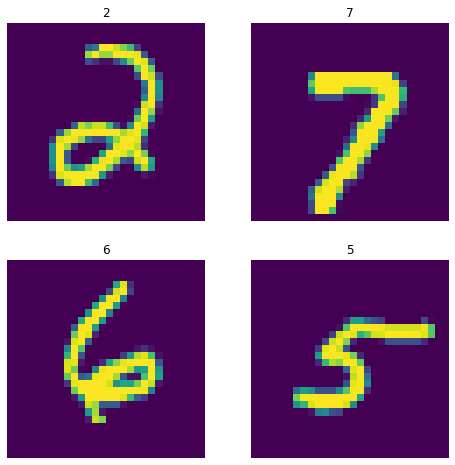

In [7]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [8]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [9]:
#--- Definimos una ANN simple sin utilizar batch_size

input_dim = 28*28
out_dim = 10
hidden = 50

learning_rate = 0.01
weight_decay = 0.01

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

# Modelo entrenado en 15 épocas sin batch_size

In [10]:
from sklearn.metrics import f1_score

n_epoch = 15

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)  

Epoch [1/15], loss: 2.3161094188690186. f1:0.042204042202629466 acc: 0.10583333671092987 
Epoch [2/15], loss: 2.267849922180176. f1:0.11735921015969963 acc: 0.21116666495800018 
Epoch [3/15], loss: 2.1909213066101074. f1:0.2549478955738322 acc: 0.3401666581630707 
Epoch [4/15], loss: 2.06748366355896. f1:0.29302971162329794 acc: 0.34583333134651184 
Epoch [5/15], loss: 1.9146331548690796. f1:0.3313424434892231 acc: 0.40833333134651184 
Epoch [6/15], loss: 1.7311033010482788. f1:0.4205555339893947 acc: 0.5040000081062317 
Epoch [7/15], loss: 1.5327568054199219. f1:0.5145558342783243 acc: 0.581166684627533 
Epoch [8/15], loss: 1.3146378993988037. f1:0.6118396259930214 acc: 0.6553333401679993 
Epoch [9/15], loss: 1.1241217851638794. f1:0.67703852121715 acc: 0.7110000252723694 
Epoch [10/15], loss: 0.9716643691062927. f1:0.7680431760544357 acc: 0.7720000147819519 
Epoch [11/15], loss: 0.8674055337905884. f1:0.7519244972699943 acc: 0.7578333616256714 
Epoch [12/15], loss: 0.7827067971229553

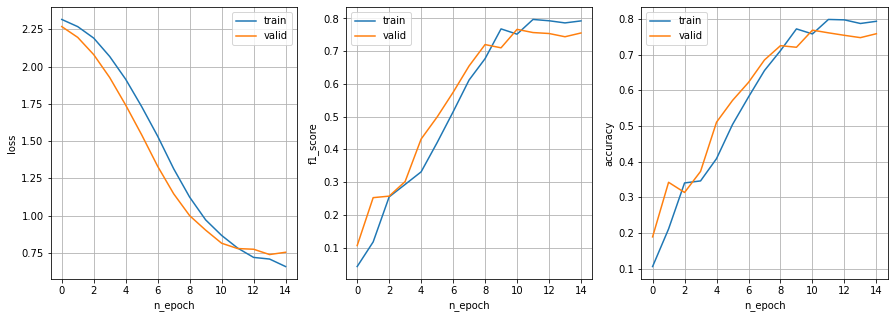

In [11]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [12]:
 #-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.6466957330703735, f1: 0.7780534339026925, acc: 0.7832661271095276


# Batch Size
El **batch_size** es un metaparametro que permite seleccionar muestras de datos más pequeñas que el conjunto completo de datos. Usar subconjuntos en el proceso de entrenamiento en vez del conjunto completo, es altamente eficiente desde el punto de vista computacional. De modo que se puede obtener un modelo de igual capacidad usando un menor número de épocas.

![](https://drive.google.com/uc?id=1I9R58FoYEr9SGtZfAakwAuwmEk_OnBds)

# Modelo entrenado en 5 épocas con batch_size

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 512

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [14]:
#--- Definimos una ANN simple sin utilizar batch_size

input_dim = 28*28
out_dim = 10
hidden = 50

learning_rate = 0.01
weight_decay = 0.01

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [15]:
n_epoch = 5

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

total_it = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()

    Xtr = X_train_batch.view(X_train_batch.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_batch,Y_pred, average='macro') )
  
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    total_it += 1

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch, loss_train[-1], f1_train[-1], acc_train[-1]) )  

Epoch [1/5], loss: 1.5093005895614624. f1:0.3769161241688435 acc: 0.4538043439388275 
Epoch [2/5], loss: 1.2597968578338623. f1:0.45594967567560696 acc: 0.4836956560611725 
Epoch [3/5], loss: 1.1960434913635254. f1:0.5386312641487773 acc: 0.5597826242446899 
Epoch [4/5], loss: 1.066349744796753. f1:0.6117409972364325 acc: 0.6195651888847351 
Epoch [5/5], loss: 1.0590521097183228. f1:0.6555691262007107 acc: 0.66576087474823 


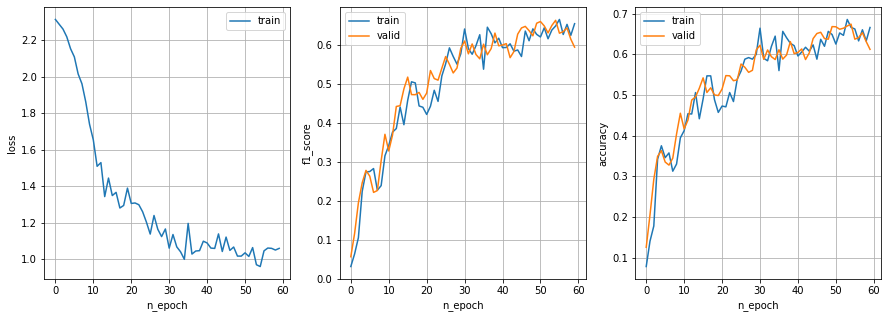

In [16]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(total_it), loss_train, label='train')
# plt.plot(range(total_it), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(total_it), f1_train, label='train')
plt.plot(range(total_it), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(total_it), acc_train, label='train')
plt.plot(range(total_it), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [17]:
 #-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 1.0936983823776245, f1: 0.6004857309955433, acc: 0.6149193644523621


# Exploración de Metaparámetros

La exploración de metaparámetros consiste en la búsqueda de los valores óptimos de estos parámetros que me arrojan los mejores resultados (*loss*, *f1_score* y el *accuracy*), evitando los problemas en el cruze de subsets, underfitting y overfitting.